In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import weighted
from torch import Tensor, nn
from serial import Serial

# Creator imports
from elasticai.creator.nn.fixed_point.quantization import quantize
from elasticai.creator.nn.fixed_point._two_complement_fixed_point_config import FixedPointConfig
from elasticai.creator.nn.fixed_point._math_operations import MathOperations
from elasticai.creator.nn import Sequential
from elasticai.creator.nn.fixed_point import Linear, Tanh, BatchNormedLinear

from package.dnn.template.dataset.autoencoder import prepare_training
from package.dnn.dnn_handler import Config_ML_Pipeline, DefaultSettings_MLPipe
from package.yaml_handler import yaml_config_handler
from package.dnn.pytorch_dataclass import (Config_Dataset, DefaultSettingsDataset)
from package.dnn.pytorch_handler import __model_settings_common, ModelRegistry

from elasticai.creator.vhdl.testbench_helper import tensor_to_vhdl_vector

### Load Dataset

In [2]:
yaml_handler = yaml_config_handler(DefaultSettings_MLPipe, 'config', 'Config_DNN')
dnn_handler = yaml_handler.get_class(Config_ML_Pipeline)
yaml_name_index='Config_AE'


yaml_data = yaml_config_handler(DefaultSettingsDataset, dnn_handler.get_path2config, f'{yaml_name_index}_Dataset')
config_data = yaml_data.get_class(Config_Dataset)

dataset = prepare_training(settings=config_data, do_classification=False,
                            mode_train_ae=dnn_handler.autoencoder_mode, noise_std=dnn_handler.autoencoder_noise_std)


models_available = ModelRegistry()

... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_DNN.yaml
... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_AE_Dataset.yaml
... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/access_cloud.yaml
... loading and processing the dataset
... do data normalization
... for training are 15894 frames with each 32 points available
... used data points for training: in total 6 classes with 15894 samples
	class 0 (Neuron #0) --> 1393 samples
	class 1 (Neuron #1) --> 1696 samples
	class 2 (Neuron #2) --> 4251 samples
	class 3 (Neuron #3) --> 3427 samples
	class 4 (Neuron #4) --> 2083 samples
	class 5 (Neuron #5) --> 3044 samples


## Load Model

### Hyperparameter

In [3]:
total_bits = 8
frac_bits = 5
num_steps = 2**8
interval = (-4, 3.96875)

In [4]:
@models_available.register
class dnn_ae_v1_Q_wo_BN(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = True
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = Sequential(
            Linear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
        )
        print(sum(p.numel() for p in self.encoder.parameters() if p.requires_grad))
        # --- Decoder Path
        self.decoder = Sequential(
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)
    
    def forward_first_layer(self, x: Tensor) -> Tensor:
        return self.encoder[0](x)
    
    def create_design(self, name):
        encoder = self.encoder.create_design(f"{name}_encoder")
        decoder = self.decoder.create_design(f"{name}_decoder")
        return encoder, decoder

In [91]:
@models_available.register
class dnn_ae_v1_wo_bn(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = False
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = nn.Sequential(
            nn.Linear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[1], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[2], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias),
        )
        # --- Decoder Path
        self.decoder = nn.Sequential(
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[2], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias),
            #nn.BatchNorm1d(iohiddenlayer[1], affine=True),
            nn.Tanh(),
            nn.Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)

In [92]:
path_to_model = "/home/silas/PycharmProjects/denspp.offline/3_Python/runs/20250127_122436_train_dnn_ae_v1_Q_wo_BN_ae/model_ae_fold000_epoch0028.pth"
path_to_fp_model = "/home/silas/PycharmProjects/denspp.offline/3_Python/runs/20250112_153952_train_dnn_ae_v1_wo_bn_ae/model_ae_fold000_epoch0029.pth"
model = torch.load(path_to_model, weights_only=False)
fp_model = torch.load(path_to_fp_model, weights_only=False)
fp_model.eval()
model.eval()

dnn_ae_v1_Q_wo_BN(
  (encoder): Sequential(
    (0): Linear(in_features=32, out_features=20, bias=True)
    (1): Tanh(
      (_base_module): Tanh()
    )
    (2): Linear(in_features=20, out_features=14, bias=True)
    (3): Tanh(
      (_base_module): Tanh()
    )
    (4): Linear(in_features=14, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Tanh(
      (_base_module): Tanh()
    )
    (1): Linear(in_features=3, out_features=14, bias=True)
    (2): Tanh(
      (_base_module): Tanh()
    )
    (3): Linear(in_features=14, out_features=20, bias=True)
    (4): Tanh(
      (_base_module): Tanh()
    )
    (5): Linear(in_features=20, out_features=32, bias=True)
  )
)

In [6]:
config = FixedPointConfig(total_bits=total_bits, frac_bits=frac_bits)
double_config = FixedPointConfig(total_bits=2*total_bits, frac_bits=2*frac_bits)
ops = MathOperations(config)
double_ops = MathOperations(double_config)
input = ops.quantize(torch.tensor(dataset[7]['in']))
print(input)
tensor_to_vhdl_vector(input, config, as_matrix=True)

tensor([-0.0312, -0.0312, -0.0312, -0.0312, -0.0312, -0.0625,  0.0000,  0.4688,
         1.0000,  0.6562, -0.1250, -0.5938, -0.5938, -0.5000, -0.4375, -0.3125,
        -0.2500, -0.1875, -0.1562, -0.1250, -0.0938, -0.0938, -0.0938, -0.0625,
        -0.0625, -0.0312, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0312])


'("11111111","11111111","11111111","11111111","11111111","11111110","00000000","00001111","00100000","00010101","11111100","11101101","11101101","11110000","11110010","11110110","11111000","11111010","11111011","11111100","11111101","11111101","11111101","11111110","11111110","11111111","11111111","00000000","00000000","00000000","00000000","00000001")'

In [44]:
input_0 = ops.quantize(torch.tensor(dataset[50]['in']))
input_1 = ops.quantize(torch.tensor(dataset[100]['in']))
input_2 = ops.quantize(torch.tensor(dataset[200]['in']))
input_3 = ops.quantize(torch.tensor(dataset[5000]['in']))
print(tensor_to_vhdl_vector(input_0, config, as_matrix=True))
print(tensor_to_vhdl_vector(input_1, config, as_matrix=True))
print(tensor_to_vhdl_vector(input_2, config, as_matrix=True))
print(tensor_to_vhdl_vector(input_3, config, as_matrix=True))

("00000001","00000001","00000001","00000000","00000000","11111110","00000000","00010011","00100000","00001111","11110111","11101100","11101100","11101111","11110001","11110011","11110101","11110111","11111000","11111011","11111101","11111111","00000000","00000000","00000000","00000000","00000000","00000000","11111111","00000000","00000000","00000000")
("00000010","00000010","00000010","00000010","00000001","00000000","00000011","00010101","00100000","00010000","11111000","11101101","11101110","11110001","11110100","11110111","11111001","11111100","11111101","11111111","11111111","00000000","11111111","11111111","11111111","11111111","11111111","11111111","00000000","00000000","00000000","00000000")
("00000000","00000000","00000000","00000000","00000000","11111110","00000011","00010110","00100000","00001101","11110110","11101101","11101111","11110001","11110011","11110110","11111000","11111010","11111011","11111100","11111101","11111101","11111110","11111110","11111110","11111110","1111

In [99]:
fpga = Serial("/dev/ttyUSB1", 115200)

def value_to_fxp(x: float) -> str:
    val = config.as_integer(x)
    return val

def inference_data_point(datapoint):
    input = torch.Tensor(datapoint['in'])
    q_input = quantize(input, total_bits=total_bits, frac_bits=frac_bits)
    
    exp_output = model(q_input)[0].detach().numpy()
    
    input_as_fxp = [value_to_fxp(data.item()).to_bytes(1, 'little', signed=True) for data in q_input]
    
    real_output = []
    
    for idx, input in enumerate(input_as_fxp):
        fpga.write(input)
        
    for idx, output in enumerate(exp_output):
        out = fpga.read(1)
        out = int.from_bytes(out, 'little', signed=True)
        real_output.append(config.as_rational(out))
    
    return {'exp_output':exp_output, 'real_output':real_output}

In [100]:
inference_data_point(dataset.__getitem__(5000))

{'exp_output': array([0.53125, 0.78125, 0.5    ], dtype=float32),
 'real_output': [0.53125, 0.78125, 0.5]}

In [82]:
dataset.__len__()

15894

In [83]:
from tqdm import tqdm

output = list(dict())

data = list(dict())
for i in range(0, 15894, 50):
    data.append(dataset.__getitem__(i))

for datapoint in tqdm(data, desc="Progress"):
    out_dict = inference_data_point(datapoint)
    output.append(out_dict)

Progress: 100%|██████████| 318/318 [00:10<00:00, 30.22it/s]


## Calculate SMAPE Scores

In [84]:
smape_scores = []

for out in output:
    exp_output = out['exp_output']
    real_output = out['real_output']
    smape = np.mean(
        np.abs(real_output - exp_output) / ((np.abs(real_output) + np.abs(exp_output)) / 2)
    ) * 100
    smape_scores.append(smape)

/tmp/ipykernel_60444/2674103882.py:7: RuntimeWarning: invalid value encountered in divide
  np.abs(real_output - exp_output) / ((np.abs(real_output) + np.abs(exp_output)) / 2)


In [85]:
print(smape_scores[50])

0.0


/tmp/ipykernel_60444/776477003.py:2: RuntimeWarning: Mean of empty slice
  mean_smapes_100 = [np.nanmean(smape_scores[steps:steps+100]) for steps in range(0, 15894, 100)]


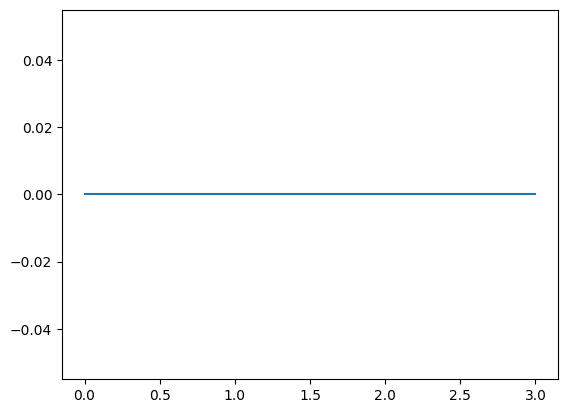

In [89]:
# Calculate the mean MAPE
mean_smapes_100 = [np.nanmean(smape_scores[steps:steps+100]) for steps in range(0, 15894, 100)]
plt.plot(mean_smapes_100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


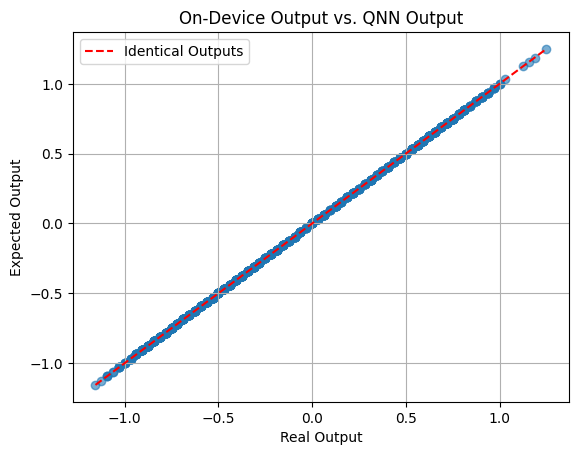

In [104]:
all_real = np.concatenate([out['real_output'] for out in output])
all_exp = np.concatenate([out['exp_output'] for out in output])

plt.scatter(all_real, all_exp, alpha=0.6)
plt.plot([all_real.min(), all_real.max()], [all_real.min(), all_real.max()], 'r--', label='Identical Outputs')
plt.title('On-Device Output vs. QNN Output')
plt.xlabel('Real Output')
plt.ylabel('Expected Output')
plt.legend()
plt.grid(True)

plt.savefig(f'on_device_inference.eps', format='eps')
plt.show()

## Calculate Loss